<a href="https://colab.research.google.com/github/arefosco/data_science/blob/master/An%C3%A1lise_de_desmatamento_ilegal_Terra_Ind%C3%ADgena.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Projeto de Análise de Desmatamento Ilegal na Terra Indígena Igarapé Laje - Rondônia**#
<p style="text-align: justify;">
Nos últimos anos, a acessibilidade aos dados geoespaciais tem aumentado drasticamente. Na última década, em particular, vimos uma explosão na disponibilidade de dados de satélite de alta qualidade, com muitos deles sendo oferecidos gratuitamente.

As imagens de satélite desempenham um papel importante, fornecendo dados cruciais para prever desastres, compreender as mudanças climáticas e garantir o fornecimento de água, entre muitos outros usos.

Essas imagens, provenientes de várias fontes como NASA, USGS, NOAA e ESA, incluem uma ampla gama de informações, como temperatura da superfície terrestre, vegetação e outros parâmetros biofísicos. Sendo assim, permitem uma compreensão mais detalhada do nosso planeta e a capacidade de monitorar e prever uma variedade de fenômenos naturais e induzidos pelo homem.

Neste notebook, iremos explorar o Google Earth Engine (GEE), uma plataforma que coloca esses recursos de dados à nossa disposição. O Google Earth Engine oferece um catálogo de imagens e dados ambientais vasto e atualizado, que inclui dados históricos de satélites de observação da Terra que remontam a décadas.

O desmatamento para a extração ilegal de diamantes e ouro em terras indígenas na Amazônia é um dos principais problemas ambientais e sociais enfrentados na região. Essa prática criminosa envolve a destruição indiscriminada de florestas e ecossistemas valiosos para obter recursos minerais preciosos, muitas vezes sem consideração pelos impactos devastadores que causa ao meio ambiente e às comunidades indígenas que dependem dessas terras para sua subsistência e cultura. O desmatamento ilegal associado à mineração tem consequências alarmantes para a biodiversidade, o ciclo hidrológico, o equilíbrio climático global e a qualidade de vida das populações locais. Neste contexto, é fundamental buscar soluções sustentáveis e eficazes para coibir essa prática e garantir a preservação da Amazônia e o respeito aos direitos dos povos indígenas.

Neste projeto prático, nós desenvolveremos uma análise objetiva dos pontos de desmatamento na **Terra Indígena Igarapé Laje em Rondônia**, parte mais meridional da amazônia brasileira, onde há ampla concentração de reservas destinadas a proteção da cultura e dos costumes dos primeiros habitantes do continente.

A seguir iremos explorar um pouco mais as ferramentas e dados utilizados no desenvolvimento deste projeto.</p>

## 1. Google Earth Engine (Python API)##
<p style="text-align: justify;">
1.1 Acessar e autenticar no Google Earth Engine

Para acessar e aproveitar todos os recursos gratuitos disponibilizados, você precisa ter uma conta no Google e solicitar acesso à plataforma do Google Earth Engine. Uma vez que o acesso seja concedido, você pode começar a usar o Editor de Código do Google Earth Engine para escrever e executar scripts para acessar, analisar e visualizar os dados disponíveis.</p>

In [ ]:
# Importar as bibliotecas necessárias
import ee
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Exibição dos gráficos diretamente no notebook
%matplotlib inline

# Configuração da biblioteca do matplotlib para usar 'grey' como mapa de cores padrão para imagens
plt.rcParams['image.cmap'] = 'gray'

# Importação da biblioteca gdal da osgeo, usada para manipular arquivos geoespaciais
from osgeo import gdal

In [ ]:
# disparar fluxo de autenticação
ee.Authenticate()

# inicializar a biblioteca
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=XWYiNrWWXnekLJPZDO21BlENOmPRR54L1w8r2KzdyWs&tc=gHFIvz_n51sFOcB0oY8YP0dH173rho0NWXhsM9C12zc&cc=ELCn8L1A8WrkdVlknj0tD8PqPiarHw62dwqCuwZKFHQ

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfJohXnrr0E4EXrWxoOzu1fglUL2vNdaWO0vpf6xFKBnPJRRTMSAfFHFL3o

Successfully saved authorization token.


In [ ]:
print(ee.Image("NASA/NASADEM_HGT/001").get("title").getInfo())

NASADEM: NASA NASADEM Digital Elevation 30m


In [ ]:
ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_044034_20201028')

### 1.2 Extrair imagens (GeoTiff) do Google Earth Engine ###
<p style="text-align: justify;">
Extrair imagens do Google Earth Engine envolve a execução de scripts para solicitar e processar dados de imagens de satélite. A plataforma do Google Earth Engine permite que você selecione uma coleção de imagens específica, aplicaremos filtros temporais e espaciais para selecionar as imagens que atendam às necessidades do projeto e, em seguida, aplicaremos algoritmos de processamento de imagem para manipular os dados da imagem. Assim podemos, por exemplo, extrair a vegetação ou dados de cobertura do solo, realizar análises de mudança ao longo do tempo, entre outras funções.</p>

In [ ]:
def cloud_mask_l8(image):
    qa = image.select('QA_PIXEL')

    # Bits 3 and 5 are cloud shadow and cloud, respectively.
    cloudShadowBitMask = 1 << 3
    cloudsBitMask = 1 << 5

    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
              .And(qa.bitwiseAnd(cloudsBitMask).eq(0))\

    return image.updateMask(mask)

In [ ]:
# Importar a coleção USGS Landsat 8 Level 2, Collection 2, Tier 1
# lc = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')

# Define um polígono em torno da Terra Indígena Igarapé Laje, Rondônia.
geometry = ee.Geometry.Polygon(
       [[[-64.77463861917947, -10.416881663058305],
         [-65.30177667365894, -10.416881663058305],
         [-65.30177667365894, -10.652374265103091],
         [-64.77463861917947, -10.652374265103091]]],
         None, False)

# Define os parâmetros para Landsat 8.
landsat8_params = {
    "bands": ['SR_B4', 'SR_B3', 'SR_B2'],
    "min": 0.0,
    "max": 30000.0,
    "gamma": 1.0
}

# Filtra a imagem da coleção do Landsat 8 pelo ano de 2013 e aplica a máscara de nuvens.
dataset13 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2013-01-01', '2013-12-31').map(cloud_mask_l8)
landsat13 = dataset13.median().clip(geometry)

# Filtra a imagem da coleção do Landsat 8 pelo ano de 2018 e aplica a máscara de nuvens.
dataset18 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2018-01-01', '2018-12-31').map(cloud_mask_l8)
landsat18 = dataset18.median().clip(geometry)

# Filtra a imagem da coleção do Landsat 8 pelo ano de 2013 e aplica a máscara de nuvens.
dataset23 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2023-01-01', '2023-12-31').map(cloud_mask_l8)
landsat23 = dataset23.median().clip(geometry)

### 1.3 Exibir imagens de satélite em mapas##
<p style="text-align: justify;">
Uma das principais vantagens do Google Earth Engine é sua capacidade de visualizar dados de sensoriamento remoto de maneira eficaz. Após a seleção e o processamento dos dados da imagem, podemos exibir as imagens de satélite em um mapa interativo. Isso é feito adicionando as imagens processadas como camadas em um Mapa do Google Earth Engine. Este mapa pode ser explorado e manipulado interativamente, permitindo uma visão clara e detalhada dos dados.</p>


In [ ]:
import folium

def add_ee_layer(self, ee_image_object, vis_params, name):
    """
    Adiciona uma camada de imagem do Google Earth Engine a um mapa do Folium.

    Args:
          self (object): Objeto do mapa folium ao qual a camada será adicionada.
          ee_image_object (ee.image.Image): Imagem do Google Earth Engine para ser adicionada ao mapa folium.
          vis_params (dict): Parâmetros de visualização para a imagem.
            Este dicionário deve conter pelo menos uma propriedade 'bands'.
            Por exemplo, {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'max': 0.3}
          name (str): Nome da camada que será adicionada.

    Retorna:
          None

    Exemplo:
          # Define um mapa folium
        mapa = folium.Map(location=[-15.783333, -47.866667], zoom_start=12)

        # Imagem do GEE
        imagem = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_220071_20170805')

        # Parâmetros de visualização
        vis = { 'bands': ['B4', 'B3', 'B2'], 'max': 0.3 }

        # Adicione a imagem ao mapa
        mapa.add_ee_layer(imagem, vis, 'Brasilia Landsat')

        # Exibe o mapa
        display(mapa)

    """

    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True,
    ).add_to(self)


# Adiciona o método de desenho do Google Earth Engine ao folium.
folium.Map.add_ee_layer = add_ee_layer

# Centraliza o mapa na Terra Indígena Igarapé Laje, Rondônia.
map = folium.Map(location = (-10.5096, -65.071), zoom_start = 10)

# Adiciona as imagens geradas ao mapa.
map.add_ee_layer(landsat13, landsat8_params, '2013')
map.add_ee_layer(landsat18, landsat8_params, '2018')
map.add_ee_layer(landsat23, landsat8_params, '2023')

# Adiciona um painel de controle de camadas ao mapa.

map.add_child(folium.LayerControl())

# Exibe o mapa.
display(map)


### 1.4 Salvar imagens do Google Earth como GeoTiff##
<p style="text-align: justify;">
O Google Earth Engine permite exportar dados processados, incluindo imagens de satélite, em uma variedade de formatos. Um dos formatos mais comuns é o GeoTiff, que é um formato de imagem TIFF que inclui metadados geoespaciais, permitindo que a imagem seja usada em sistemas de informação geográfica (GIS). Para salvar imagens como GeoTiff, precisamos definir uma tarefa de exportação no Editor de Código do Google Earth Engine e escolher o Google Drive como destino da exportação. A imagem processada será salva em nosso Google Drive, pronto para ser baixado e usado em outras análises ou visualizações GIS.</p>

In [ ]:
task_config = {
    'folder': 'desflorestamento',
    'scale': 30,
    'region': geometry,
    'fileFormat':"GeoTIFF",
    'maxPixels': 1e9,
    'formatOptions': {
        'cloudOptimized': True
    }

}

task1 = ee.batch.Export.image.toDrive(landsat13, description = '2013api', **task_config)
task2 = ee.batch.Export.image.toDrive(landsat18, description = '2018api', **task_config)
task3 = ee.batch.Export.image.toDrive(landsat23, description = '2023api', **task_config)

In [ ]:
task1.start()
task2.start()
task3.start()

In [ ]:
task1.status()

{'state': 'COMPLETED',
 'description': '2013api',
 'creation_timestamp_ms': 1697121728329,
 'update_timestamp_ms': 1697124979265,
 'start_timestamp_ms': 1697124678430,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://drive.google.com/#folders/1Xc6Eh_RvgAzFlvQlqs5_00nsnttEWbJw'],
 'attempt': 1,
 'batch_eecu_usage_seconds': 302.5960388183594,
 'id': 'OSIZUFCJQO45GFWVJEJ7IBXS',
 'name': 'projects/earthengine-legacy/operations/OSIZUFCJQO45GFWVJEJ7IBXS'}

In [ ]:
task2.status()

{'state': 'READY',
 'description': '2018api',
 'creation_timestamp_ms': 1697121587592,
 'update_timestamp_ms': 1697121587592,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': 'K44CTOUGAPMDLDCDVVLXNUXZ',
 'name': 'projects/earthengine-legacy/operations/K44CTOUGAPMDLDCDVVLXNUXZ'}

In [ ]:
task3.status()

{'state': 'READY',
 'description': '2023api',
 'creation_timestamp_ms': 1697121588775,
 'update_timestamp_ms': 1697121588775,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': 'J4HTQRMZVP4RJNVKWRN2WNI6',
 'name': 'projects/earthengine-legacy/operations/J4HTQRMZVP4RJNVKWRN2WNI6'}

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## 2. Geospatial Data Abstraction Library
<p style="text-align: justify;">
A GDAL, Biblioteca de Abstração de Dados Geoespaciais, é uma ferramenta valiosa para trabalhar com formatos de dados geoespaciais raster e vetoriais. O pacote GDAL Python fornece uma série de ferramentas que permitem programar e manipular esses dados de forma eficiente.

Um conceito importante na manipulação de imagens geoespaciais é o de **banda raster**. Imagens coloridas comuns geralmente têm 3 bandas raster, que representam os componentes de intensidade de luz azul, verde e vermelha. No entanto, uma banda raster pode conter qualquer conjunto de valores de células que representem a mesma área espacial, não se limitando apenas às informações de intensidade de luz.

Extrair dados raster através da GDAL é feito uma banda por vez. A função `GetRasterBand()` nos permite extrair uma única banda raster da imagem GeoTiff.

### Sintaxe da Função
```python
band = dataset.GetRasterBand( n )
```

A função possui **1 argumento de entrada obrigatório**:

1. `n` é o número do canal a ser extraído.

Para saber mais, você pode consultar a [documentação do GDAL](https://gdal.org/api/python/osgeo.gdal.html).

Neste exemplo, estamos trabalhando com uma imagem GeoTIFF do Landsat8 que contém diversas bandas, listadas abaixo:

1. Coastal/Aerosol
2. Blue
3. Green
4. Red
5. Near Infrared
6. Shortwave Infrared 1
7. Shortwave Infrared 2
8. Panchromatic
9. Cirrus
10. Thermal Infrared 1
11. Thermal Infrared 2

Vamos visualizar cada uma dessas bandas para melhor compreensão dos dados.

</p>

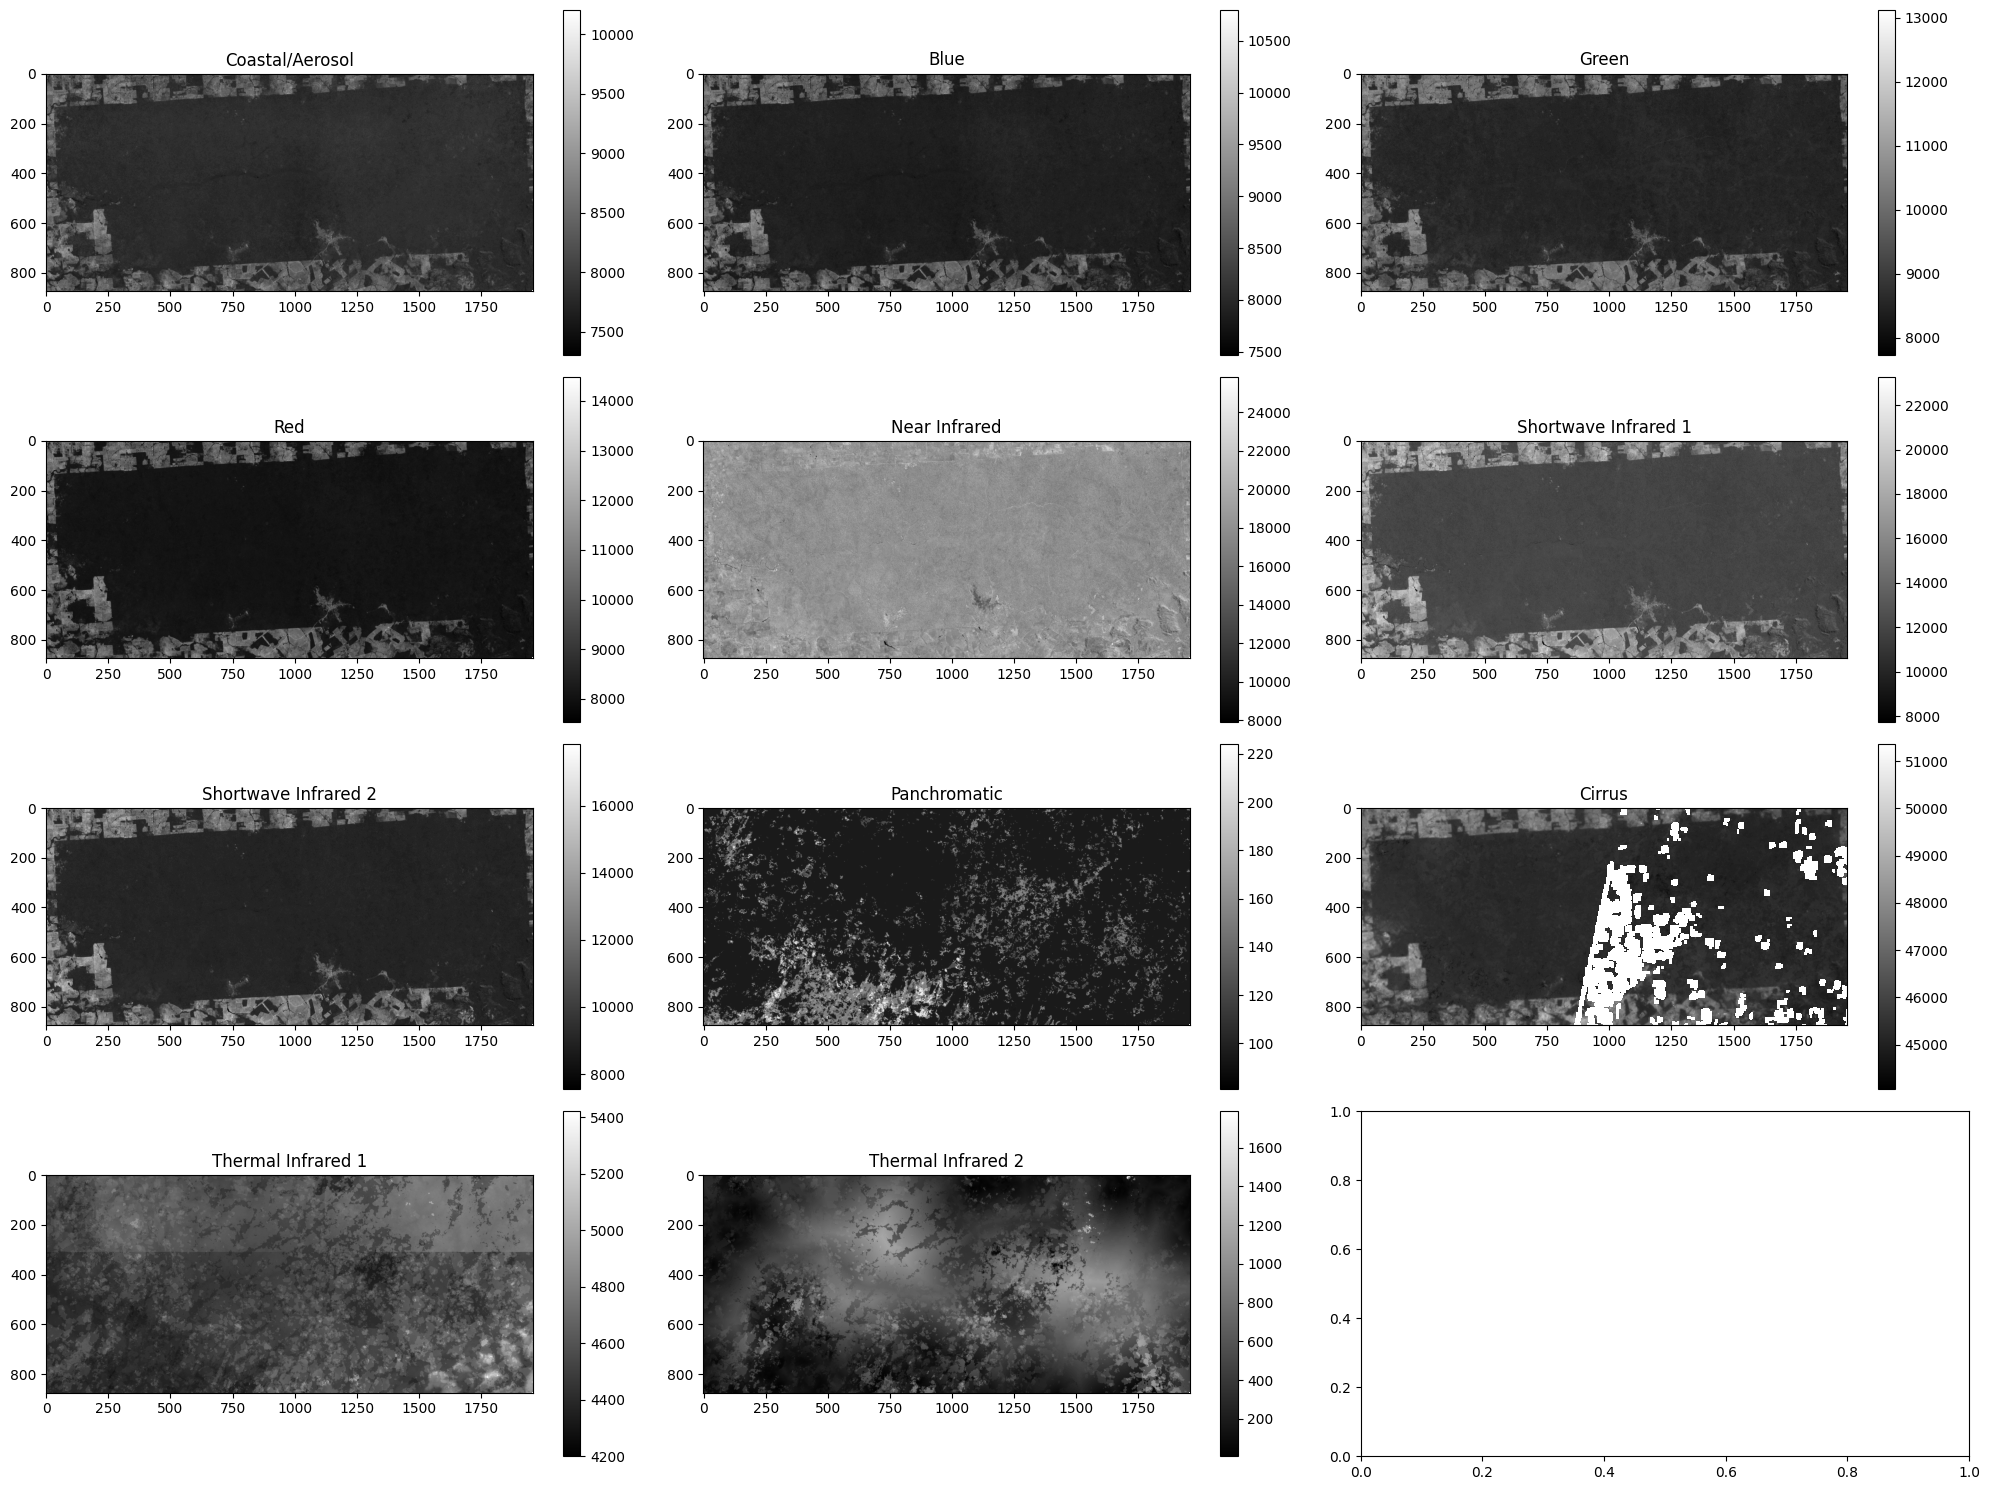

In [ ]:
# Usamos gdal para abrir um arquivo geoespacial específico
ds = gdal.Open('/content/drive/MyDrive/deforestation/2013api.tif')

# Criamos um dicionário que mapeia os números das bandas para seus nomes descritivos
band_names = {
    1: "Coastal/Aerosol",
    2: "Blue",
    3: "Green",
    4: "Red",
    5: "Near Infrared",
    6: "Shortwave Infrared 1",
    7: "Shortwave Infrared 2",
    8: "Panchromatic",
    9: "Cirrus",
    10: "Thermal Infrared 1",
    11: "Thermal Infrared 2",
}

# Criamos uma grade de subplots com 4 linhas e 3 colunas e definimos o tamanho da figura
fig, axs = plt.subplots(4, 3, figsize=(20, 15))

# Iteramos sobre cada banda e nome no dicionário band_names
for band, name in band_names.items():
    # Identificamos o subplot apropriado no qual plotar
    ax = axs[(band - 1) // 3, (band - 1) % 3]
    # Lemos os dados da banda atual como um array e os exibimos na imagem
    im = ax.imshow(ds.GetRasterBand(band).ReadAsArray())
    # Adicionamos uma barra de cores à imagem
    fig.colorbar(im, ax=ax)
    # Definimos o título do subplot com o nome da banda
    ax.set_title(name)

# Usamos tight_layout para garantir que os subplots não se sobreponham
plt.tight_layout()

# Exibimos a figura
plt.show()

## 3. Índice de Diferença Normalizada da Vegetação (NDVI)
<p style="text-align: justify;">
O **Índice de Diferença Normalizada da Vegetação** ou NDVI é um índice que é utilizado para demonstrar a diferença entre a refletância visível e próxima do infravermelho da cobertura vegetal e **pode ser usado para estimar a densidade de verde em uma área de terra**.

O NDVI é calculado conforme a seguinte fórmula:

$$
NDVI = \frac{(NIR - RED)}{(NIR  + RED)}
$$

onde `RED` e `NIR` representam as medidas de refletância espectral adquiridas nas regiões vermelha (visível) e próxima do infravermelho, respectivamente. O índice NDVI para uma área com vegetação deve estar entre 0.3 (vegetação leve) a 0.8 (vegetação densa). Nuvens terão um índice negativo, enquanto solo e corpos de água terão valores positivos baixos. Usaremos essas informações para estimar a vegetação de uma determinada região.

Em valores normalizados, ou seja, entre (0, 255), o intervalo de interesse corresponde às intensidades compreendidas entre 165 e 230.

**Região Próxima ao Infravermelho (NIR)**

A região **NIR** tem um comprimento de onda de 0.76 - 0.90 µm. A vida vegetal absorve luz visível de 0.4 µm (luz azul) até 0.7 µm (luz vermelha) para fotossíntese, com absorção máxima em ambas as extremidades deste espectro. Vemos as plantas como verdes porque elas normalmente não absorvem os comprimentos de onda verdes da luz (~0.5 µm) no meio desta faixa. No entanto, isso torna o canal verde menos preciso para a detecção de vegetação porque está dentro da gama completa de comprimentos de onda utilizados para a fotossíntese. Por outro lado, as plantas refletem fortemente a luz próxima do infravermelho (de 0.7 a 1.1 µm). Este fato é explorado no cálculo do NDVI.
</p>

In [ ]:
def get_NDVI(ds):
    '''
    Calcula o Índice de Vegetação da Diferença Normalizada (NDVI) para uma imagem.

    Argumentos:
    ds -- Um objeto de conjunto de dados GDAL aberto que representa a imagem

    Retorna:
    ndvi -- Uma matriz numpy representando o NDVI da imagem
    '''
    r = ds.GetRasterBand(4).ReadAsArray()   # Banda Vermelha é a 4ª
    nir = ds.GetRasterBand(5).ReadAsArray() # Banda NIR é a 5ª
    ndvi = (nir - r)/(nir + r)
    ndvi = normalize255(ndvi)
    return ndvi

def normalize255(ndvi):
    '''
    Normaliza uma matriz de NDVI para a faixa de 0 a 255.

    Argumentos:
    ndvi -- Uma matriz numpy representando o NDVI

    Retorna:
    ndvi -- A matriz NDVI normalizada
    '''
    ndvi = ndvi + 1
    ndvi = (ndvi / 2) * 255
    return ndvi

def get_NDVI_mask(ndvi):
    '''
    Cria uma máscara de limiar para áreas de vegetação em uma matriz de NDVI.

    Argumentos:
    ndvi -- Uma matriz numpy representando o NDVI

    Retorna:
    mask -- Uma matriz binária onde os valores de 1 representam vegetação
    '''
    _, mask = cv2.threshold(ndvi, 170, 255, cv2.THRESH_BINARY)
    return mask

def percent_forest(mask):
    '''
    Calcula a porcentagem de pixels de vegetação em uma máscara.

    Argumentos:
    mask -- Uma matriz binária onde os valores de 1 representam vegetação

    Retorna:
    percent -- A porcentagem de pixels de vegetação
    '''
    c = cv2.countNonZero(mask)
    t = mask.shape[0] * mask.shape[1]
    return round((c / t) * 100, 4)

def plot_NDVI(path):
    '''
    Plota o NDVI e a máscara de vegetação de uma imagem e exibe a porcentagem de vegetação.

    Argumentos:
    path -- O caminho para o arquivo da imagem
    '''
    ds = gdal.Open(path)
    ndvi = get_NDVI(ds)
    ndvi_mask = get_NDVI_mask(ndvi)

    year = path.split('.')[0][:4]
    fig = plt.figure(figsize = (20, 5))
    fig = plt.subplot(1, 2, 1)
    plot = plt.imshow(ndvi, cmap = "gray")
    plt.colorbar()
    plt.title(year + ": " + "NDVI")
    plt.xticks([]), plt.yticks([])
    fig = plt.subplot(1, 2, 2)
    plot = plt.imshow(ndvi_mask, cmap = "gray");
    plt.title(str(percent_forest(ndvi_mask)) + "%")
    plt.xticks([]), plt.yticks([])
    plt.show()

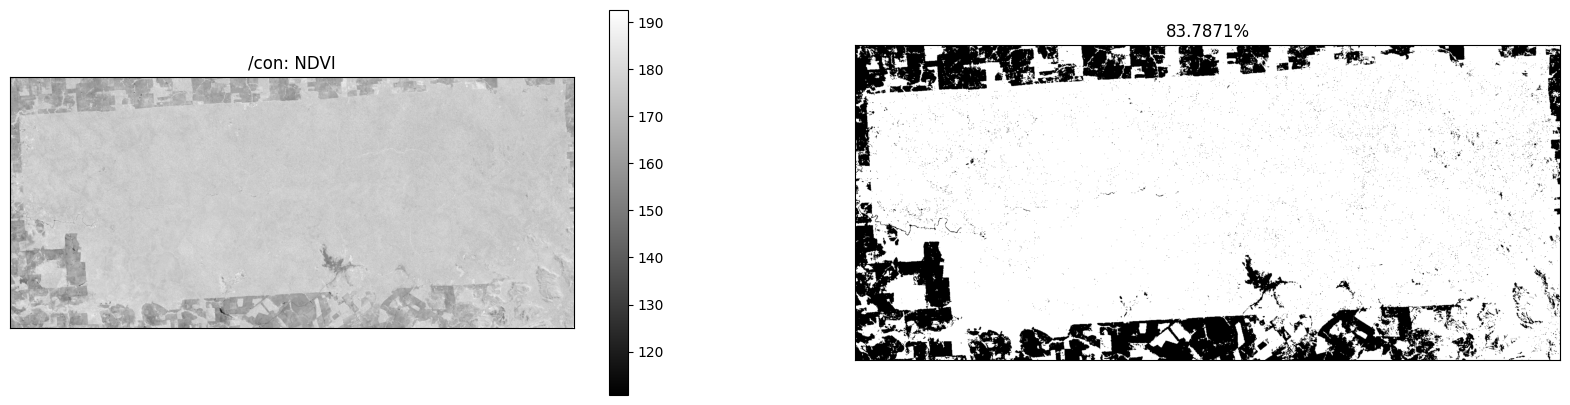

In [ ]:
plot_NDVI("/content/drive/MyDrive/deforestation/2013api.tif")

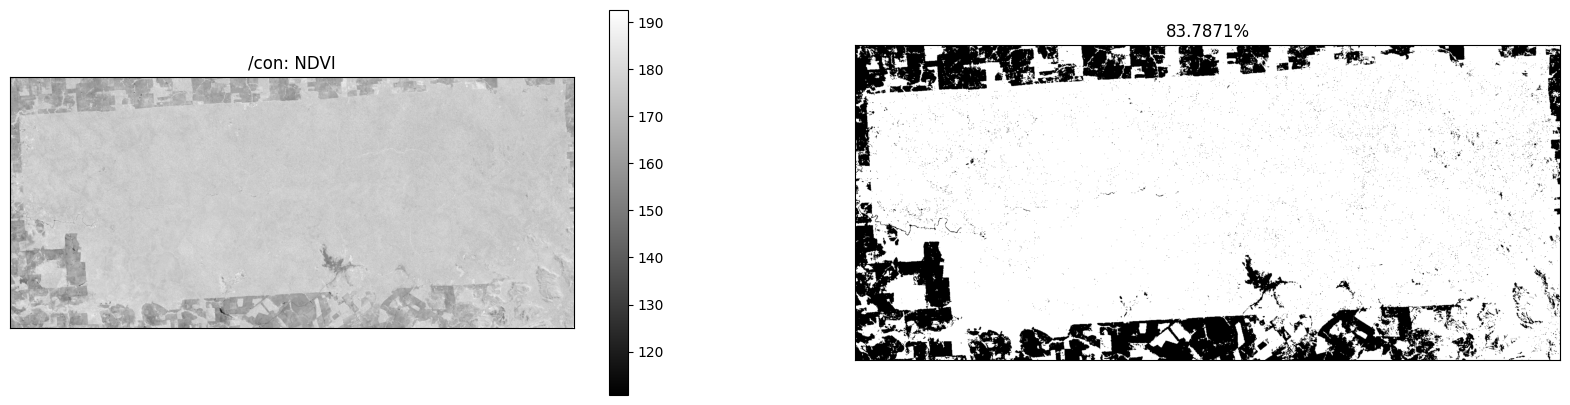

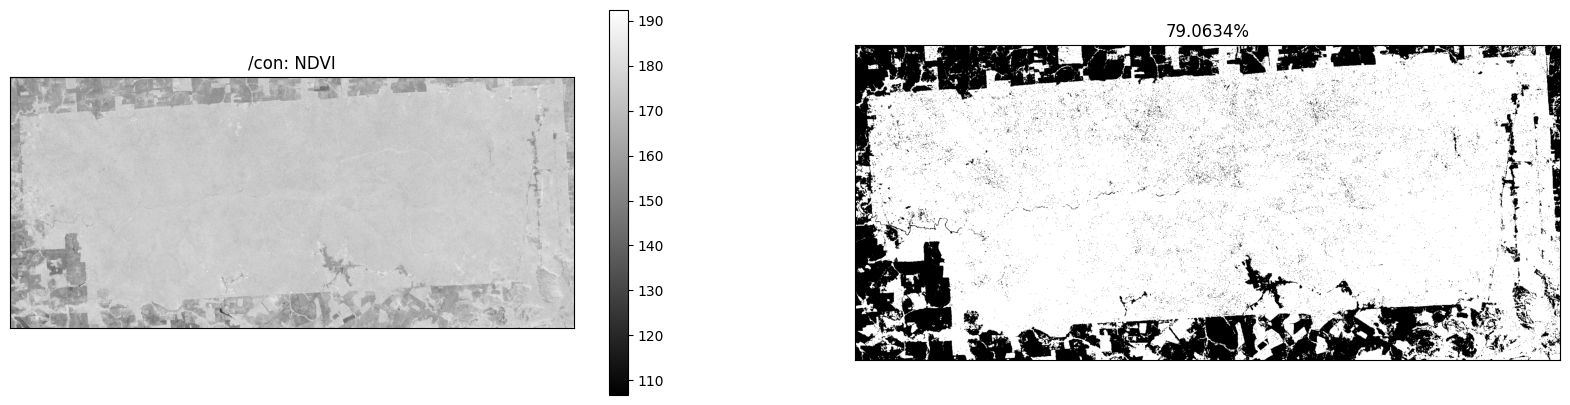

In [ ]:
files = [
    "/content/drive/MyDrive/deforestation/2013api.tif",
    "/content/drive/MyDrive/deforestation/2023api.tif"
]

for file in files:
  plot_NDVI(file)

## **4. Resultados** ##
<p style="text-align: justify;">
Como podemos observar nas imagens acima, o percentual de área verde da Terra Indígena Igarapé Laje decaiu de 83,79% para 79,06%, ou seja, 4,73% entre os anos de 2013 a 2023.
<br></br>
Esta redução, não representa em si, indícios consideráveis de desmatamento na região, pois, neste mesmo período a população indígena que ali vive teve um salto demográfico de aproximadamente 800 para cerca de 1100 habitantes. Ou seja, mais de 35%.
<br></br>

Neste contexo, é improvável afirmar que exista a presença de garimpeiros ilegais explorando minérios, como ouro e diamante, na Terra Igarapé Laje de forma agressiva, uma vez que, o salto demográfico poderia explicar a redução da área de floresta preservada nesa Terra Indígena.
<br></br>

Por outro lado, este projeto pode ser aplicado em outras regiões do país com o mesmo intuito de identificar possíves atividades de garimpo ilegal em Terras Indígenas através da análise do aumento inesperado do destamamento causado pela extração dos minérios.
<br></br>
Este tipo de análise utilizada isoladamente auxilia mas não é determinante para o combate ao garimpo ilegal de minérios na amazônia. Mas, pode ser um ponto de partida para, combinada com ferramentas de aprendizado de máquina, inteligência artificial e análises específicas para a identificação de jazidas, aumentar a robustez da estrutura de combate e monitoramento de atividades criminosas.
<br></br>
Com este projeto esperamos ter ajudado a aprimorar soluções que contribuam para o aumento e a melhoria de ações de monitoramento da floresta amazônica e preservação dos recursos naturais. Não podemos deixar de citar que esta é uma análise preliminar e que excluiu diversas variáveis que poderiam explicar a variação da área verde de floresta da Terra Igarapé.
</p>